In [2]:
import cvxpy as cp
import numpy as np

from copy import deepcopy

In [26]:
np.array([[0, 2, 3, 4, 1], [1, 4, 5, 3, 2]]).T, np.array([[0, 2, 3, 4, 1], [1, 4, 5, 3, 2]]).T

(array([[0, 1],
        [2, 4],
        [3, 5],
        [4, 3],
        [1, 2]]),
 array([[0, 1],
        [2, 4],
        [3, 5],
        [4, 3],
        [1, 2]]))

In [2]:
class OneTimeLearner:

    def __init__(self, epsilon, n, b):
        self.epsilon = epsilon
        self.n = n
        self.b = deepcopy(b)
        self.f = []
        self.g = []
        self.x = []
        self.t = 0
        self.s = int(epsilon * n)
        self.p_hat = None
        self.allocation_check_rhs = deepcopy(b)

    def process_input(self, new_f, new_g):
        
        # increment t and add new pi and a values
        self.t += 1
        self.f.append(new_f)
        self.g.append(new_g)

        if self.t <= self.s:
            new_x = 0
            if self.t == self.s:
                # solve LP to find p_hat using learning phase data
                
                # problem data
                cvx_g = np.array(self.g)
                cvx_f = np.array(self.f)
                cvx_b = np.c_[self.b]
                
                # construct the problem
                p = cp.Variable((len(self.b), 1))
                y = cp.Variable((self.s, 1))
                
                constraints = []
                for i in range(self.s):
                    total = np.ones_like(cvx_f[0])
                    for j in range(len(self.b)):
                        total += cvx_g[j][i] * p[j]
                    constraints.append(total <= cvx_f[i])
                
                constraints += [p >= 0, y >= 0]
                
                const = (1 - self.epsilon) * self.s / self.n 
                objective = cp.Minimize(const * cvx_b.T @ p + cp.sum(y))
                prob = cp.Problem(objective, constraints)
                prob.solve()
                self.p_hat = p.value.T.tolist()[0]  # save p
        else:            
            # determine allocation amount for the current bid
            allocation = np.zeros((s))
            rhs = 0
            for i in range(len(self.b)):
                rhs += self.p_hat[i] * self.g[-1][i]
            if np.all(self.f[-1] > rhs):
                allocation = 1
            
            # determine whether to allocate towards the new bid 
            for i in range(len(self.b)):
                if allocation * self.a[-1][i] > self.allocation_check_rhs[i]:
                    new_x = 0
                    break
            else:
                new_x = allocation

        self.x.append(new_x)
        for i in range(len(self.b)):
            self.allocation_check_rhs[i] -= self.a[-1][i] * self.x[-1]
        return new_x
    
    def get_x(self):
        return self.x

In [3]:
class DynamicLearner:

    def __init__(self, epsilon, n, b):
        self.epsilon = epsilon
        self.n = n
        self.b = deepcopy(b)
        self.pi = []
        self.a = []
        self.x = []
        self.t = 0
        self.s = int(epsilon * n)
        self.p_hat = None
        self.allocation_check_rhs = deepcopy(b)
        self.r = np.floor(np.log2(self.s / self.epsilon / self.n)) - 1

    def process_input(self, new_pi, new_a):
        # increment t and add new pi and a values
        self.t += 1
        self.pi.append(new_pi)
        self.a.append(new_a)
        
        # print(self.allocation_check_rhs)

        if self.t <= self.s:
            new_x = 0
        else:        
            
            # check if we need to update p_hat
            if 2 ** (self.r + 1) * self.epsilon * self.n < self.t:
                self.r += 1
                # solve LP to find p_hat using learning phase data           
                # problem data
                cvx_a = np.array(self.a).T
                cvx_pi = np.c_[self.pi]
                cvx_b = np.c_[self.b]

                # construct the problem
                p = cp.Variable((len(self.b), 1))
                y = cp.Variable((self.t, 1))
                const = (1 - self.epsilon * np.sqrt(self.n  / self.t)) * self.t / self.n 
                objective = cp.Minimize(const * cvx_b.T @ p + cp.sum(y))
                constraints = [cvx_a.T @ p + y >= cvx_pi, p >= 0, y >= 0]
                prob = cp.Problem(objective, constraints)
                prob.solve()
                self.p_hat = p.value.T.tolist()[0]  # save p

            # determine allocation amount for the current bid
            allocation = 0
            rhs = 0
            for i in range(len(self.b)):
                rhs += self.p_hat[i] * self.a[-1][i]
            if self.pi[-1] > rhs:
                allocation = 1

            # determine whether to allocate towards the new bid 
            for i in range(len(self.b)):
                if allocation * self.a[-1][i] > self.allocation_check_rhs[i]:
                    new_x = 0
                    break
            else:
                new_x = allocation
            
        # update choices made
        self.x.append(new_x)
        for i in range(len(self.b)):
            self.allocation_check_rhs[i] -= self.a[-1][i] * self.x[-1]

        return new_x
    
    def get_choices(self):
        return self.x

In [122]:
N = 100
k = 10
b = [1000] * 5

# problem data


# N = 100
# k = 10
# b = [1000] * 5

# # problem data


# top = np.array([np.random.choice([0, 1], p=[1 - 0.5 ** 3, 0.5 ** 3], size=(N * k)) for _ in range(len(b))])

# vals = np.array([np.random.rand(N * k) for _ in range(len(b))]) * top

# cvx_fs = np.zeros((k, N))
# for i in range(N):
#     cvx_fs[:, i] = np.sum(vals[:, i*k:i*k+k], axis=0)
    
# bot = np.zeros((N, N * k))
# for i in range(N):
#     bot[i, i*k:i*k+k] = np.ones(k)

# cvx_gs = np.concatenate([top, bot], axis=0)

# cvx_b = np.c_[b]

# x = cp.Variable((k, N))
# constraints = []

# for j in range(N):
#     constraints.append(cp.sum(x[:, j]) == 1)
#     constraints.append(x >= 0)
        


cvx_b = np.c_[b]
cvx_gs = np.array([[np.random.choice([0, 1], p=[1 - 0.5 ** 3, 0.5 ** 3], size=k) for _ in range(len(b))] for _ in range(N)])
cvx_fs = np.sum(np.random.rand(N, len(b), k) * cvx_gs, axis=1)

x = cp.Variable((N, k))
constraints = []
for i in range(len(b)):
    for j in range(N):
        constraints.append(cp.sum(cp.multiply(cvx_gs[j][i], x[j])) <= cvx_b[i])

for j in range(N):
    constraints.append(cp.sum(x[j]) == 1)
    constraints.append(x[j] >= 0)
        
objective = cp.Maximize(cp.sum([cp.sum(cp.multiply(x[j], cvx_fs[j])) for j in range(N)]))
prob = cp.Problem(objective, constraints)
prob.solve()
prob.value

117.03653309668891

In [126]:
cvx_fs[0]

array([0.        , 0.        , 0.76135404, 1.31459793, 0.        ,
       0.        , 0.        , 0.        , 0.69650183, 0.79822257])

In [4]:
N = 10_000
b = [1000] * 5
a = np.array([np.random.choice([0, 1], p=[1 - 0.5 ** 3, 0.5 ** 3], size=N) for _ in b])
pi = np.sum(np.random.rand(5, N) * a, axis=0)

In [5]:
# problem data

cvx_b = np.c_[b]
cvx_pi = np.c_[pi]

# construct the problem
x = cp.Variable((N, 1))
objective = cp.Maximize(cvx_pi.T @ x)
constraints = [a @ x <= cvx_b, x >= 0, x <= 1]
prob = cp.Problem(objective, constraints)
prob.solve()
prob.value

2934.2336501641976

In [6]:
for eps in [0.2, 0.15, 0.1, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
    alg = OneTimeLearner(eps, N, b)
    for i in range(N):
        alg.process_input(pi[i], list(a[:, i].T))
    print(1 - pi.T @ np.c_[alg.get_x()] / prob.value)

[0.26128592]
[0.17974676]
[0.15187476]
[0.08160301]
[0.06744577]
[0.07612494]
[0.12206905]
[0.10783678]
[0.17587556]
[0.18836403]


In [7]:
for eps in [0.2, 0.15, 0.1, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
    alg = DynamicLearner(eps, N, b)
    for i in range(N):
        alg.process_input(pi[i], list(a[:, i].T))
    print(1 - pi.T @ np.c_[alg.get_choices()] / prob.value)

[0.35109951]
[0.25826292]
[0.17365804]
[0.10431335]
[0.09101467]
[0.07995562]
[0.06440963]
[0.05483]
[0.04634147]
[0.03985471]


In [8]:
one_time_rl = []
dynamic_rl = []

for eps in [0.2, 0.15, 0.1, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
    
    one_time_vals = []
    dynamic_vals = []
    
    for _ in range(100):
        
        idx = np.random.permutation(N)
        
        a = a[:, idx]
        pi = pi[idx]

        alg = OneTimeLearner(eps, N, b)
        for i in range(N):
            alg.process_input(pi[i], list(a[:, i].T))
        one_time_vals.append(1 - pi.T @ np.c_[alg.get_x()] / prob.value)

        alg = DynamicLearner(eps, N, b)
        for i in range(N):
            alg.process_input(pi[i], list(a[:, i].T))
        dynamic_vals.append(1 - pi.T @ np.c_[alg.get_choices()] / prob.value)
    
    print("Done", eps)
    one_time_rl.append(np.average(one_time_vals))
    dynamic_rl.append(np.average(dynamic_vals))

Done 0.2
Done 0.15
Done 0.1
Done 0.07
Done 0.06
Done 0.05
Done 0.04
Done 0.03
Done 0.02
Done 0.01


In [9]:
one_time_rl

[0.28594397592486454,
 0.21696781970731954,
 0.14930099686011297,
 0.111321160308105,
 0.10195762822701222,
 0.1008645894418271,
 0.10197736473818172,
 0.10291371452934467,
 0.11001212942865085,
 0.14026465402166843]

In [10]:
dynamic_rl

[0.3621559131151843,
 0.27929351856691775,
 0.18739749565794062,
 0.13383432650309446,
 0.11483926052655309,
 0.09537514053720189,
 0.07760910287309869,
 0.05754418778360175,
 0.04244410664203694,
 0.02833854217421432]

In [59]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})

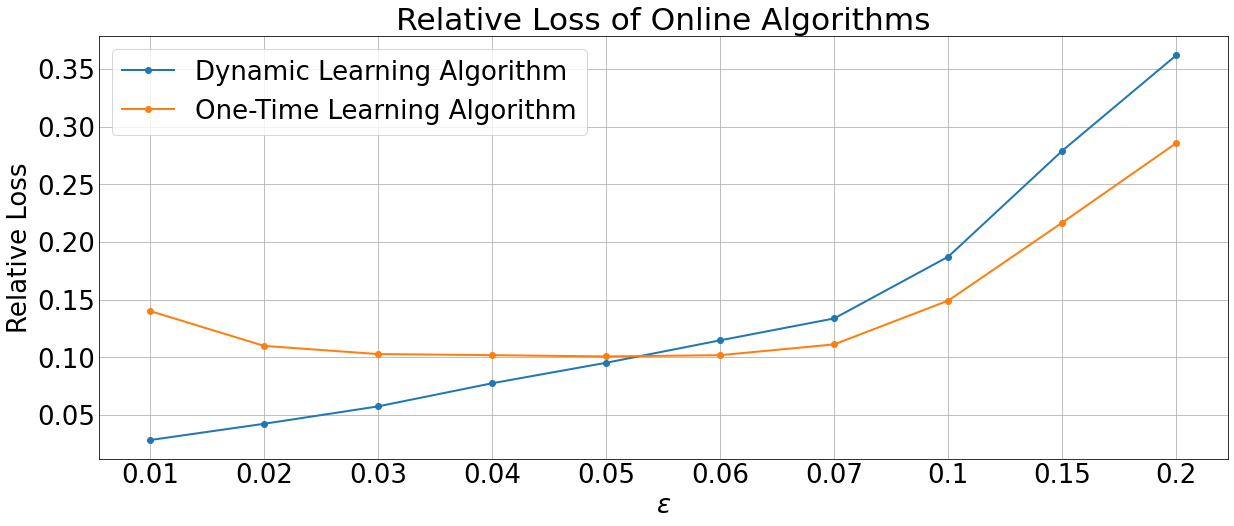

In [60]:
plt.style.use('_mpl-gallery')

epsilons = [0.2, 0.15, 0.1, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
xs = range(len(epsilons), 0, -1)

# plot
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(xs, dynamic_rl, "o-", linewidth=2.0, label="Dynamic Learning Algorithm")
ax.plot(xs, one_time_rl, "o-", linewidth=2.0, label="One-Time Learning Algorithm")

ax.set(xticks=xs, 
       xticklabels=epsilons,
       title="Relative Loss of Online Algorithms", 
       xlabel=r"$\epsilon$", 
       ylabel="Relative Loss",
)

ax.legend()

plt.show()